Follow this guide to select the correct conda environment\
https://stackoverflow.com/questions/66869413/visual-studio-code-does-not-detect-virtual-environments

In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '128'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
#print(sys.executable)
from importlib import reload

import collections
import os
import subprocess
import numpy as np

import confidence.confidence_tools as confidence_tools

from IPython import display
from collections import defaultdict
import py3Dmol
import pandas as pd
#pd.set_option('display.max_columns', None)

# import drawing library
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# CHANGE
id="8av2"
model=(4,2)
prediction=(29,2)
preset="default"


# CHANGE
id="7x8t"
model=(1,4)
prediction=(2,29)
preset="default"

#id="8h63"
# model=(1,4)
# prediction=(2,29)
# preset="default"

In [4]:
# Software
MMalign_exe="/home/sfromm/programs/MMalign/MMalign"

# Directories
tmp = "/home/sfromm/tmp"
native_pdb = f"/home/sfromm/git/abag-benchmark-set/data/db/structures_filtered/{id}_filtered.pdb"
path_scores = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/scores.csv"
all_scores = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/scores_{preset}.csv"

#f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model}_multimer_v3_pred_{prediction}_{preset}/{id}_model_{model}_multimer_v3_pred_{prediction}_{preset}_merged.csv"


# Parameters
pdb1_cut = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}/{id}_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}_cut_query.pdb"
pdb2_cut = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}/{id}_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}_cut_query.pdb"
pdb1 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/unrelaxed_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}.pdb"
pdb2 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/unrelaxed_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}.pdb"
pkl1 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/result_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}.pkl"
pkl2 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/result_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}.pkl"


In [5]:
df = pd.read_csv(path_scores, sep=',')
df = pd.read_csv(all_scores, sep=',')

In [6]:
df = df.sample(n=356, random_state=42)  # Set random_state for reproducibility

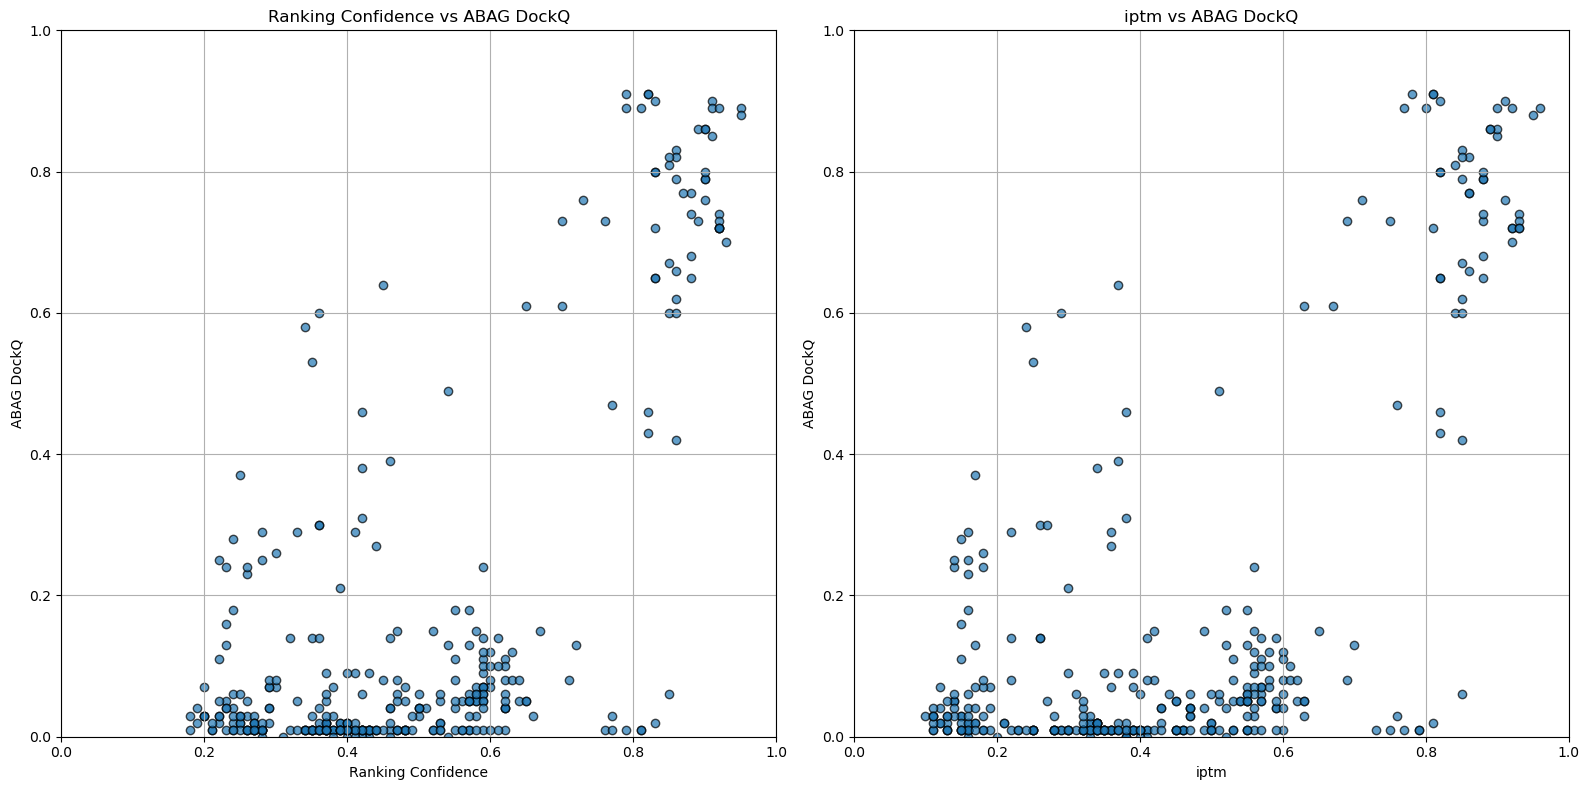

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop rows where ranking_confidence, custom_score, or abag_dockq is NaN
#df = df.dropna(subset=["ranking_confidence", "custom_score", "abag_dockq"])


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot ranking_confidence vs abag_dockq
axes[0].scatter(df["ranking_confidence"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0].set_xlabel("Ranking Confidence")
axes[0].set_ylabel("ABAG DockQ")
axes[0].set_title("Ranking Confidence vs ABAG DockQ")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0, 1)
axes[0].grid(True)

# Plot custom_score vs abag_dockq
axes[1].scatter(df["iptm"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1].set_xlabel("iptm")
axes[1].set_ylabel("ABAG DockQ")
axes[1].set_title("iptm vs ABAG DockQ")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0, 1)
axes[1].grid(True)



# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Predicted TM terms

In [8]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Function to extract features from a matrix
def extract_features(matrix):
    """Extracts various statistical features from an n x n matrix, handling NaNs and extreme values."""
    # Ensure matrix has no NaNs or Infs
    matrix = np.nan_to_num(matrix, nan=0.0, posinf=1e10, neginf=-1e10)
    
    # Compute determinant safely using slogdet, ensuring the matrix is not empty
    sign, logdet = np.linalg.slogdet(matrix) if matrix.shape[0] == matrix.shape[1] and np.any(matrix) else (0, np.nan)
    
    features = {
        "mean": np.mean(matrix),
        "std": np.std(matrix),
        "min": np.min(matrix),
        "max": np.max(matrix),
        "sum": np.sum(matrix),
        "median": np.median(matrix),
        "trace": np.trace(matrix),
        #"log_determinant": logdet  # More stable than determinant
    }
    return features

# Function to compute correlation between extracted features and abag_dockq
def compute_correlations(df, feature_columns, score_column):
    correlations = {}
    df = df.copy()
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')
    df[score_column] = pd.to_numeric(df[score_column], errors='coerce')

    for feature in feature_columns:
        unique_vals = df[feature].nunique()
        if unique_vals > 1:  # Ensure at least two unique values
            try:
                pearson_corr, pearson_pval = stats.pearsonr(df[feature], df[score_column])
                spearman_corr, spearman_pval = stats.spearmanr(df[feature], df[score_column])
                correlations[feature] = {
                    "pearson_correlation": pearson_corr,
                    "pearson_p_value": pearson_pval,
                    "spearman_correlation": spearman_corr,
                    "spearman_p_value": spearman_pval,
                }
            except:
                correlations[feature] = {
                    "pearson_correlation": "x",
                    "pearson_p_value": "x",
                    "spearman_correlation": "x",
                    "spearman_p_value": "x",
                }
    
    return pd.DataFrame(correlations).T

# Main processing loop
def analyze_pae_correlation(df):
    feature_list = []
    
    for index, row in df.iterrows():
        # Extract required fields
        preset = row["preset"]
        id_ = row["sample_id"].split("_")[0]
        model = row["model"]
        prediction = row["prediction"]
        
        # Construct pickle file path
        features_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id_}complex/features.pkl"
        asym_id = confidence_tools.load_data_from_pkl(features_path)["asym_id"]
        
        pkl_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id_}complex/result_{model}_pred_{prediction}_{preset}.pkl"
        pkl_data = confidence_tools.load_data_from_pkl(pkl_path)
        
        try:
            pae = pkl_data["predicted_aligned_error"]
            if pae is None:
                continue
            
            # Ensure PAE matrix has no NaNs or Infs
            pae = np.nan_to_num(pae, nan=0.0, posinf=1e10, neginf=-1e10)
            
            # Compute features for whole matrix
            global_features = extract_features(pae)
            global_features["sample_id"] = row["sample_id"]
            
            # Compute features for each submatrix
            unique_ids = np.unique(asym_id)

            # Create a dictionary of masks
            masks = {}
            for i, g1 in enumerate(unique_ids):
                for j, g2 in enumerate(unique_ids):
                    row_mask = asym_id == g1
                    col_mask = asym_id == g2
                    mask = np.outer(row_mask, col_mask)  # Creates the submatrix mask
                    masks[(g1, g2)] = mask
                    submatrix = pae * mask
                    sub_features = extract_features(submatrix)
                    for key, value in sub_features.items():
                        global_features[f"submatrix_{i}_{j}_{key}"] = value
                
            feature_list.append(global_features)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            continue

        # Compute features for interface region (where asym_id differs)
        interface_mask = asym_id[:, None] != asym_id[None, :]
        if np.any(interface_mask):  # Ensure interface mask is not empty
            interface_matrix = pae * interface_mask
            interface_features = extract_features(interface_matrix)
            for key, value in interface_features.items():
                global_features[f"interface_{key}"] = value
        else:
            print(f"Skipping interface features for sample {row['sample_id']} (empty mask)")
    
    # Convert to DataFrame
    features_df = pd.DataFrame(feature_list)
    #print(features_df)
    
    # Merge with original dataframe to align with abag_dockq
    df = df.merge(features_df, on="sample_id", how="inner")
    
    # Compute correlation between extracted features and abag_dockq
    feature_columns = [col for col in df.columns if (col.startswith("submatrix") or col in global_features) and col != "sample_id"]
    
    correlation_results = compute_correlations(df, feature_columns, "abag_dockq")
    
    return correlation_results, df

# Example usage
# df should be your input dataframe containing "abag_dockq"
# correlation_results, updated_df = analyze_pae_correlation(df)
# print(correlation_results)

In [23]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression

# Function to extract features from a matrix
def extract_features(matrix):
    """Extracts various statistical features from an n x n matrix, handling NaNs and extreme values."""
    # Ensure matrix has no NaNs or Infs
    matrix = np.nan_to_num(matrix, nan=0.0, posinf=1e10, neginf=-1e10)
    
    # Compute determinant safely using slogdet, ensuring the matrix is not empty
    sign, logdet = np.linalg.slogdet(matrix) if matrix.shape[0] == matrix.shape[1] and np.any(matrix) else (0, np.nan)
    
    features = {
        "mean": np.mean(matrix),
        "std": np.std(matrix),
        "min": np.min(matrix),
        "max": np.max(matrix),
        "sum": np.sum(matrix),
        "median": np.median(matrix),
        "trace": np.trace(matrix),
    }
    return features

# Function to compute correlation and mutual information between extracted features and abag_dockq
def compute_correlations(df, feature_columns, score_column):
    correlations = {}
    df = df.copy()
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')
    df[score_column] = pd.to_numeric(df[score_column], errors='coerce')

    # Compute Pearson, Spearman, and Mutual Information
    mi_scores = mutual_info_regression(df[feature_columns], df[score_column])
    mi_results = pd.Series(mi_scores, index=feature_columns)
    
    for feature in feature_columns:
        unique_vals = df[feature].nunique()
        if unique_vals > 1:  # Ensure at least two unique values
            try:
                pearson_corr, pearson_pval = stats.pearsonr(df[feature], df[score_column])
                spearman_corr, spearman_pval = stats.spearmanr(df[feature], df[score_column])
                mi_score = mi_results[feature]
                correlations[feature] = {
                    "pearson_correlation": pearson_corr,
                    "pearson_p_value": pearson_pval,
                    "spearman_correlation": spearman_corr,
                    "spearman_p_value": spearman_pval,
                    "mutual_information": mi_score,
                }
            except:
                correlations[feature] = {
                    "pearson_correlation": "x",
                    "pearson_p_value": "x",
                    "spearman_correlation": "x",
                    "spearman_p_value": "x",
                    "mutual_information": "x",
                }
    
    return pd.DataFrame(correlations).T

# Main processing loop
def analyze_pae_correlation(df):
    feature_list = []
    
    for index, row in df.iterrows():
        # Extract required fields
        preset = row["preset"]
        id_ = row["sample_id"].split("_")[0]
        model = row["model"]
        prediction = row["prediction"]
        
        # Construct pickle file path
        features_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id_}complex/features.pkl"
        asym_id = confidence_tools.load_data_from_pkl(features_path)["asym_id"]
        
        pkl_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id_}complex/result_{model}_pred_{prediction}_{preset}.pkl"
        pkl_data = confidence_tools.load_data_from_pkl(pkl_path)
        
        try:
            pae = pkl_data["predicted_aligned_error"]
            if pae is None:
                continue
            
            # Ensure PAE matrix has no NaNs or Infs
            pae = np.nan_to_num(pae, nan=0.0, posinf=1e10, neginf=-1e10)
            
            # Compute features for whole matrix
            global_features = extract_features(pae)
            global_features["sample_id"] = row["sample_id"]
            
            # Compute features for each submatrix
            unique_ids = np.unique(asym_id)

            if False:
                # Create a dictionary of masks
                masks = {}
                for i, g1 in enumerate(unique_ids):
                    for j, g2 in enumerate(unique_ids):
                        row_mask = asym_id == g1
                        col_mask = asym_id == g2
                        mask = np.outer(row_mask, col_mask)  # Creates the submatrix mask
                        masks[(g1, g2)] = mask
                        submatrix = pae * mask
                        sub_features = extract_features(submatrix)
                        for key, value in sub_features.items():
                            global_features[f"submatrix_{i}_{j}_{key}"] = value
                    
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            continue

        # Compute features for interface region (where asym_id differs)
        interface_mask = asym_id[:, None] != asym_id[None, :]
        if np.any(interface_mask):  # Ensure interface mask is not empty
            interface_matrix = pae * interface_mask
            interface_features = extract_features(interface_matrix)
            for key, value in interface_features.items():
                global_features[f"interface_{key}"] = value

            interchain_mask = asym_id[:, None] == asym_id[None, :]
            aligned_confidence_probs = pkl_data['aligned_confidence_probs']
            per_alignment = confidence_tools.calculate_predicted_tm_score(
                        aligned_confidence_probs*interchain_mask[:,:,np.newaxis],return_per_alignment=True
                    )
            
            custom_iptm = confidence_tools.calculate_predicted_tm_score(
                        aligned_confidence_probs*per_alignment[:,np.newaxis,np.newaxis], asym_id=asym_id,interface=True
            )

            global_features["custom_iptm"] = custom_iptm.item()
        else:
            print(f"Skipping interface features for sample {row['sample_id']} (empty mask)")
        
        feature_list.append(global_features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(feature_list)
    print(features_df)
    
    # Merge with original dataframe to align with abag_dockq
    df = df.merge(features_df, on="sample_id", how="inner")
    
    # Compute correlation between extracted features and abag_dockq
    feature_columns = [col for col in df.columns if (col.startswith("submatrix") or col in global_features) and col != "sample_id"]
    feature_columns+=["iptm"]
    correlation_results = compute_correlations(df, feature_columns, "abag_dockq")
    
    return correlation_results, df

# Example usage
# df should be your input dataframe containing "abag_dockq"
# correlation_results, updated_df = analyze_pae_correlation(df)
# print(correlation_results)


In [24]:

correlation_results, updated_df = analyze_pae_correlation(df)



          mean        std   min        max          sum     median  \
0     7.978879   4.888495  0.75  31.231922  6362749.500   7.630910   
1     7.392484   4.896924  0.75  30.868196  3027961.250   6.392179   
2    17.332323  10.986914  0.75  31.491442  7099319.500  17.975761   
3     9.929482   8.157697  0.75  30.446205  1161391.875   6.749276   
4    11.515999   9.503021  0.75  30.975336  1370691.750   6.930336   
..         ...        ...   ...        ...          ...        ...   
351  13.179601   9.213288  0.75  31.594948  4840024.000  10.934519   
352  17.356598   9.998356  0.75  31.537556  5384867.000  20.812218   
353  16.329714  10.752543  0.75  31.522753  1887714.875  18.789799   
354  13.271213  11.273287  0.75  31.212013  3812766.250   6.723605   
355  13.675759  11.137684  0.75  30.943850  2944336.250  13.367015   

          trace                                 sample_id  interface_mean  \
0    669.757080  7s07_model_1_multimer_v3_pred_11_default        4.810030   
1    

In [20]:
print(correlation_results)

                  pearson_correlation  pearson_p_value  spearman_correlation  \
mean                        -0.740212     5.383021e-63             -0.618209   
std                         -0.785273     1.063814e-75             -0.566375   
min                          0.080914     1.275547e-01              0.062592   
max                         -0.377185     1.764796e-13             -0.374520   
sum                         -0.301719     6.295422e-09             -0.573187   
median                      -0.526621     8.609395e-27             -0.547303   
trace                       -0.225379     1.763966e-05             -0.371765   
interface_mean              -0.740197     5.429925e-63             -0.540978   
interface_std               -0.796235     2.907588e-79             -0.607042   
interface_max               -0.371416     4.357055e-13             -0.366212   
interface_sum               -0.318384     7.905792e-10             -0.590476   
interface_median            -0.225247   

In [21]:
print(correlation_results.reindex(correlation_results['mutual_information'].abs().sort_values(ascending=False).index))
x = correlation_results.reindex(correlation_results['mutual_information'].abs().sort_values(ascending=False).index).index[0]

                  pearson_correlation  pearson_p_value  spearman_correlation  \
custom_iptm                  0.716611     2.396027e-57              0.532118   
trace                       -0.225379     1.763966e-05             -0.371765   
sum                         -0.301719     6.295422e-09             -0.573187   
interface_std               -0.796235     2.907588e-79             -0.607042   
interface_sum               -0.318384     7.905792e-10             -0.590476   
interface_mean              -0.740197     5.429925e-63             -0.540978   
median                      -0.526621     8.609395e-27             -0.547303   
mean                        -0.740212     5.383021e-63             -0.618209   
std                         -0.785273     1.063814e-75             -0.566375   
interface_median            -0.225247     1.784597e-05             -0.140377   
interface_max               -0.371416     4.357055e-13             -0.366212   
max                         -0.377185   

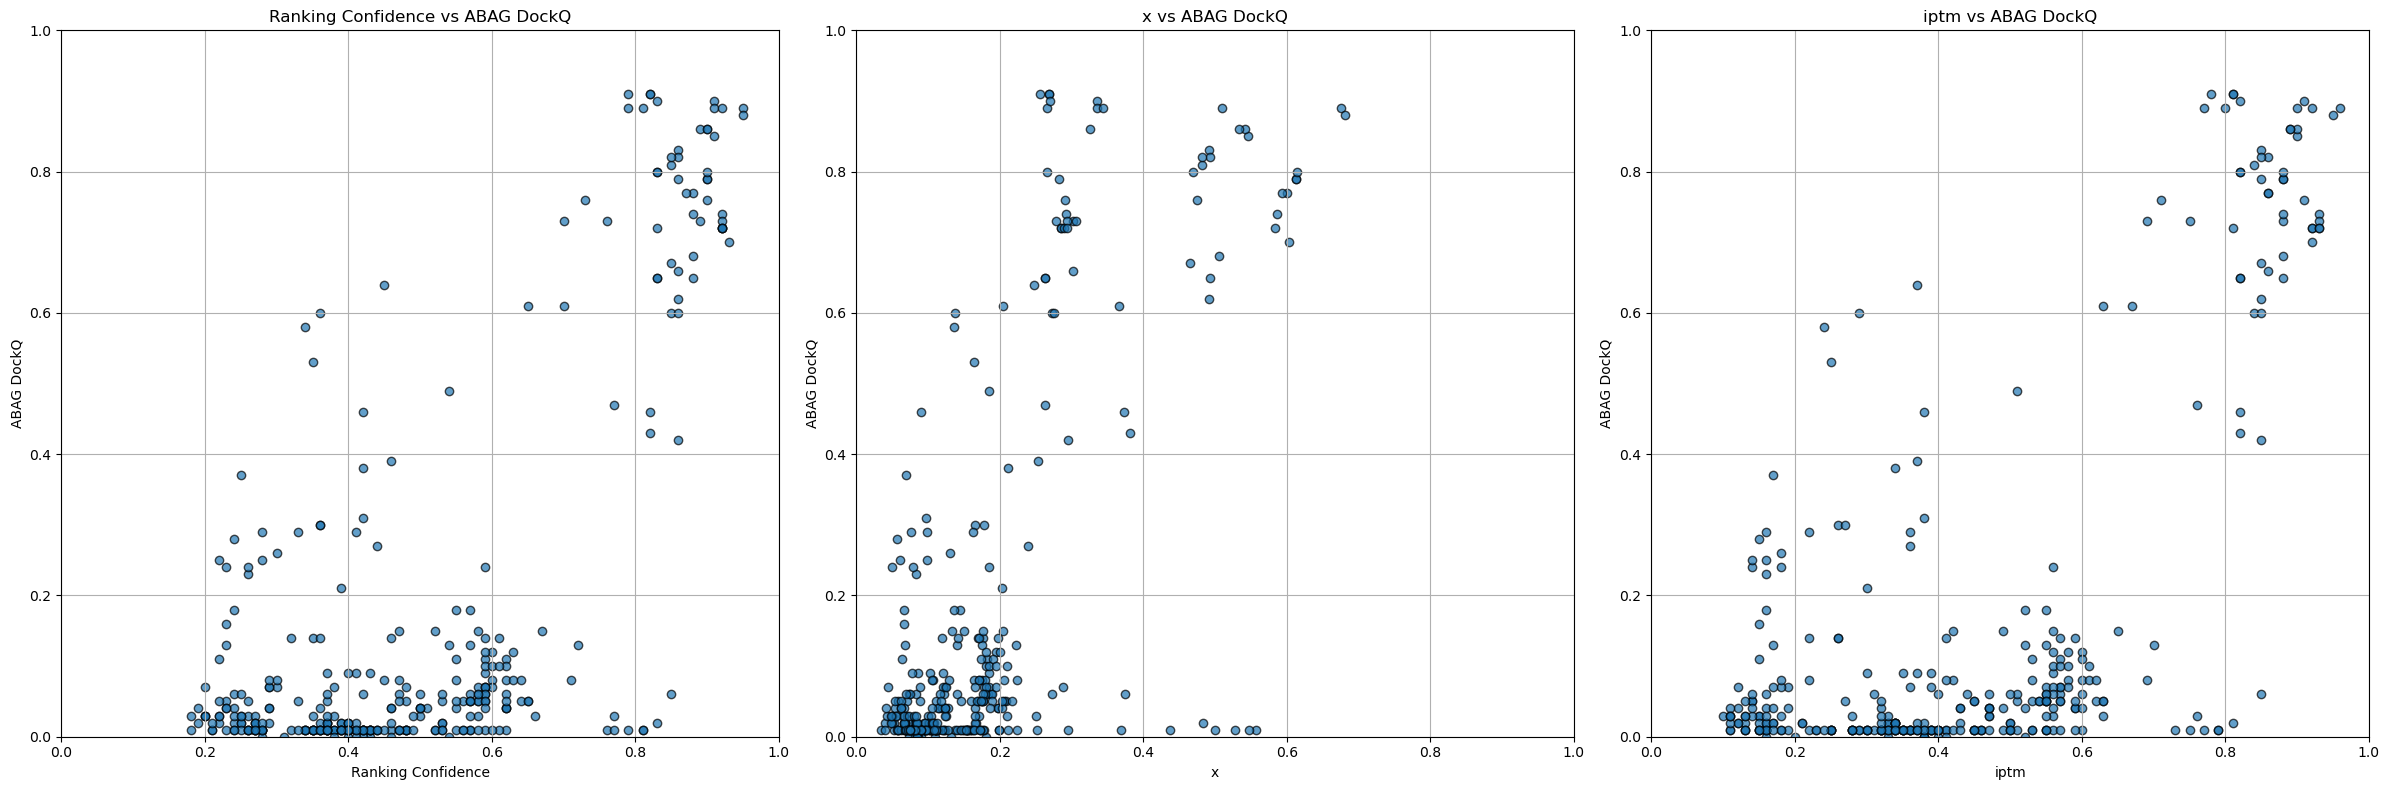

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop rows where ranking_confidence, custom_score, or abag_dockq is NaN
#df = df.dropna(subset=["ranking_confidence", "custom_score", "abag_dockq"])


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot ranking_confidence vs abag_dockq
axes[0].scatter(updated_df["ranking_confidence"], updated_df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0].set_xlabel("Ranking Confidence")
axes[0].set_ylabel("ABAG DockQ")
axes[0].set_title("Ranking Confidence vs ABAG DockQ")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0, 1)
axes[0].grid(True)

# Plot ranking_confidence vs abag_dockq
axes[2].scatter(updated_df["iptm"], updated_df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[2].set_xlabel("iptm")
axes[2].set_ylabel("ABAG DockQ")
axes[2].set_title("iptm vs ABAG DockQ")
axes[2].set_xlim(0,1)
axes[2].set_ylim(0, 1)
axes[2].grid(True)

# Plot custom_score vs abag_dockq
axes[1].scatter(updated_df["custom_iptm"], updated_df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1].set_xlabel("x")
axes[1].set_ylabel("ABAG DockQ")
axes[1].set_title("x vs ABAG DockQ")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0, 1)
axes[1].grid(True)



# Adjust layout and show the plot
plt.tight_layout()
plt.show()


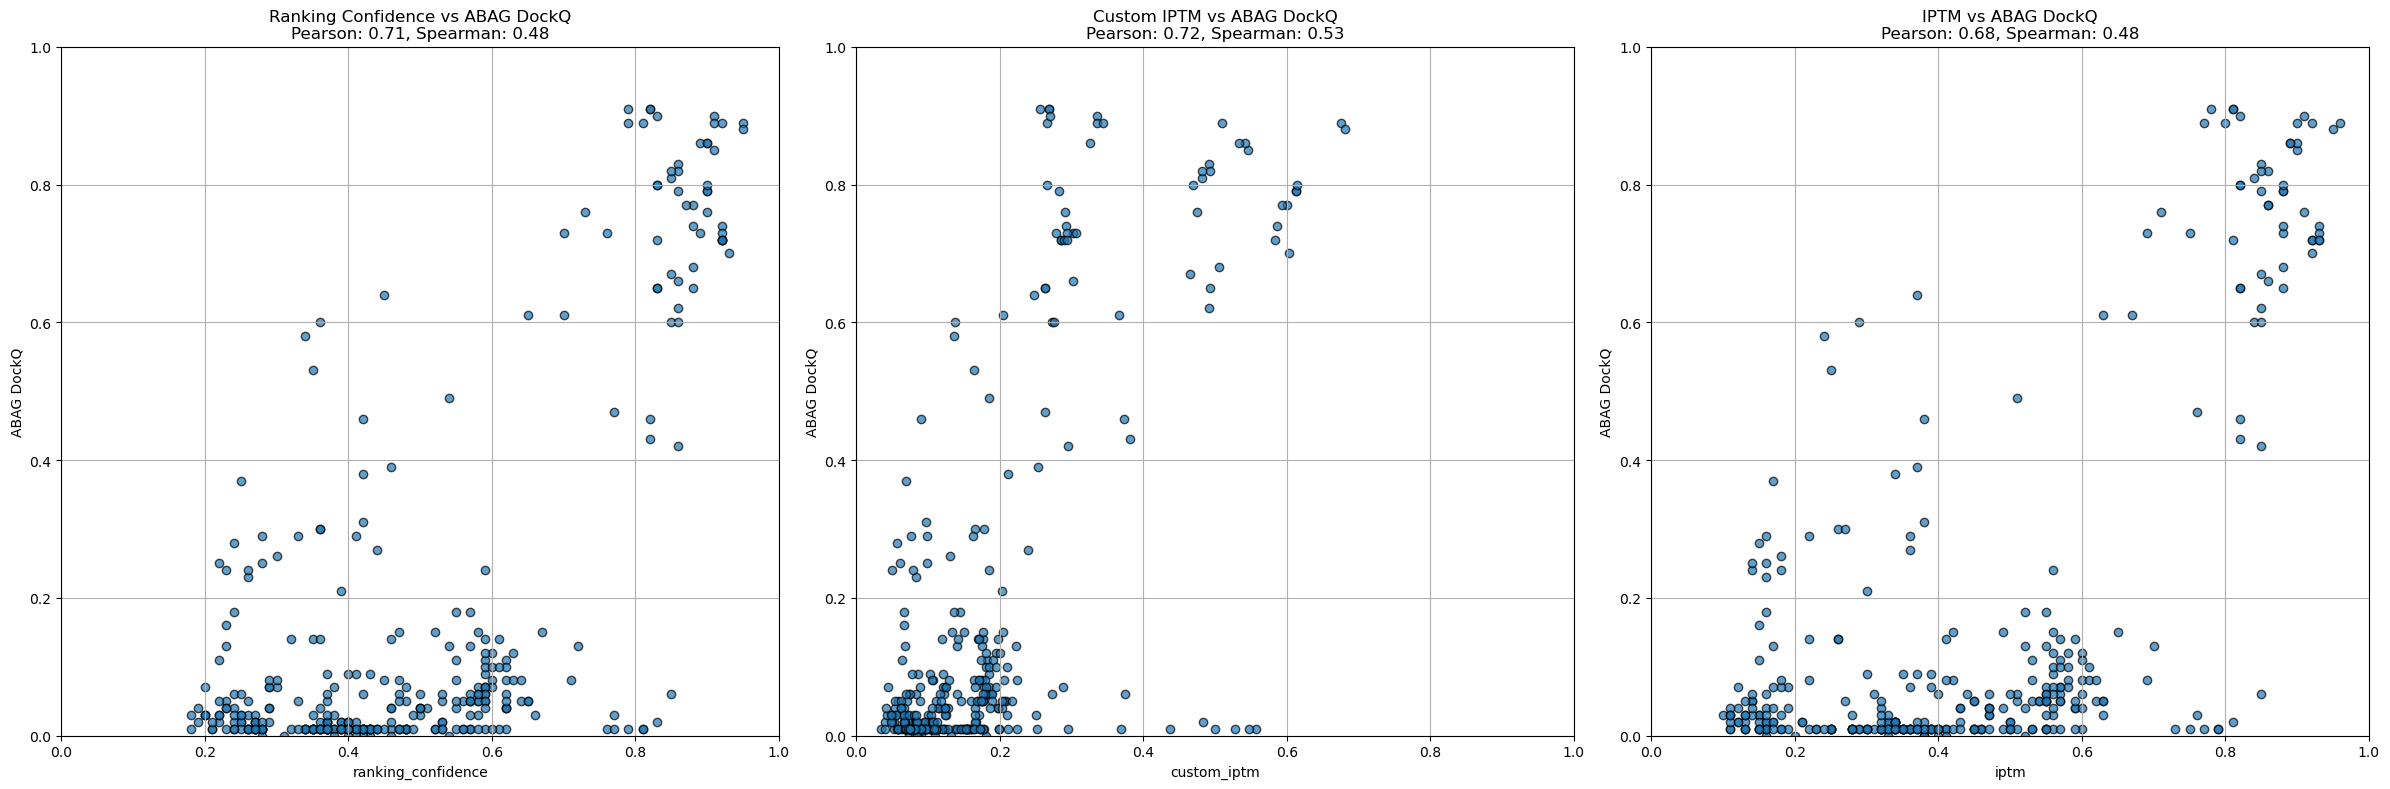

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Drop rows where ranking_confidence, custom_score, or abag_dockq is NaN
# df = df.dropna(subset=["ranking_confidence", "custom_score", "abag_dockq"])

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Define the scatter plots and correlation calculations
plot_data = [
    ("ranking_confidence", "Ranking Confidence vs ABAG DockQ"),
    ("custom_iptm", "Custom IPTM vs ABAG DockQ"),
    ("iptm", "IPTM vs ABAG DockQ")
]

for i, (x_col, title) in enumerate(plot_data):
    x = updated_df[x_col]
    y = updated_df["abag_dockq"]
    
    # Calculate Pearson and Spearman correlations
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.7, edgecolors='k')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel("ABAG DockQ")
    axes[i].set_title(f"{title}\nPearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [14]:
pkl1_data = confidence_tools.load_data_from_pkl(pkl1)
pkl2_data = confidence_tools.load_data_from_pkl(pkl2)

pdb1_structure = confidence_tools.load_pdb_structure(pdb1)
pdb2_structure = confidence_tools.load_pdb_structure(pdb2)

asym_id_1  = confidence_tools.compute_asym_id_from_pdb(pdb1_structure)
asym_id_2  = confidence_tools.compute_asym_id_from_pdb(pdb2_structure)

num_res=asym_id_1.shape[0]

aligned_confidence_probs_1=pkl1_data['aligned_confidence_probs']
aligned_confidence_probs_2=pkl2_data['aligned_confidence_probs']

predicted_tm_terms_1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1, return_predicted_tm_term=True
        )
predicted_tm_terms_2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2, return_predicted_tm_term=True
        )

per_alignment_1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1, return_per_alignment=True
        )
per_alignment_2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2, return_per_alignment=True
        )

iptm1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1, asym_id=asym_id_1,interface=True
)
iptm2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2, asym_id=asym_id_2,interface=True
)

pae1=pkl1_data['predicted_aligned_error']
pae2=pkl2_data['predicted_aligned_error']

plddt_1=pkl1_data['plddt']
plddt_2=pkl2_data['plddt']


In [15]:
# my jupyter notebook keeps crashing, maybe because of too large a variable? no idea
try:
    del pkl1_data
except:
    pass
try:
    del pkl2_data
except:
    pass


In [16]:
import matplotlib.colors as mcolors

# Some functions for drawing
plt.style.use('default')
def plot_matrix(
    mat1, mat2, filepath=None, limits1=None, limits2=None, name1="mat1", name2="mat2", title=None, figsize=7,
):

    color_map = "seismic" #"viridis"

    plot_objects = [mat1, mat2]
    limits = [limits1,limits2]
    titles = [name1,name2]
    if mat1.shape == mat2.shape:
        plot_objects.append(mat1-mat2)
        titles.append(f"{name1} - {name2}")
        if limits1==limits2:
            limits.append(limits1)
        else:
            limits.append(None)

    n_x_axis = len(plot_objects)
    fig, axes = plt.subplots(1, n_x_axis, figsize=(n_x_axis * figsize, 1 * figsize))
    for i in range(n_x_axis):

        mat = plot_objects[i]
        # Compute color normalization centered at zero
        vmin, vmax = np.min(mat), np.max(mat)
        if vmin < 0 and vmax > 0:
            norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            p = axes[i].imshow(mat, cmap=color_map, norm=norm)
        else:
            p = axes[i].imshow(plot_objects[i], cmap=color_map)
        plt.colorbar(p, ax=axes[i], fraction=0.046, pad=0.05)
        if limits[i] is not None:
            for limit in limits[i]:
                # horizontal line
                axes[i].plot([0,plot_objects[i].shape[0]-1], [limit,limit], color="red", linewidth=2) 
                # vertical line
                axes[i].plot([limit,limit], [0,plot_objects[i].shape[1]-1], color="red", linewidth=2) 
        axes[i].title.set_text(titles[i])

    if title is not None:
        fig.suptitle(title, fontsize=30)

    if filepath is not None:
        plt.savefig(filepath, dpi=600)
    else:
        plt.show()
    plt.close()
    return


def plot_vec(
    vec1, vec2,filepath=None,  limits=None, name1="vec1", name2="vec2",title=None,
):
    l = vec1.shape[0]
    assert l == vec2.shape[0]
    X = np.arange(l)

    # Figure Size

    n_x_axis = 2
    fig, axes = plt.subplots(1, n_x_axis, figsize=(n_x_axis * 7, 1 * 7))

    # vec1 and vec2
    i=0
    axes[i].bar(X + 0.00, vec1, color="blue", alpha=1, width=1)
    axes[i].bar(X + 0.00, vec2, color="green", alpha = 0.5, width=1)
    axes[i].legend(labels=[name1,name2])
    #axes[i].set_ylim((0,1))

    # difference
    i=1
    axes[i].bar(X + 0.00, vec1-vec2, color="blue", width=1)
    axes[i].legend(labels=[f"{name1}-{name2}"])


    for i in [0,1]:
        if limits is not None:
            for limit in limits:

                ax00 = axes[i].twinx()
                # Plot a line
                ax00.axvline(x=limit, color="r")

                ax00.annotate(
                    f"{limit}",
                    xy=(limit, 0),
                    xytext=(limit, -0.1),
                    arrowprops=dict(facecolor="black", shrink=0.05),
                )


    if filepath is not None:
        plt.savefig(filepath, dpi=600)
    else:
        plt.show()
    plt.close()
    return

def get_chain_limits(asym_id):
    chain_limits = []
    chain_ids = asym_id.astype("int")
    for i in range(chain_ids[-1]):
        #chain_starts = np.where(chain_ids == i + 1)[0][0] + 1
        chain_stops = np.where(chain_ids == i + 1)[0][-1] + 1
        chain_limits.append(chain_stops - 1)
    chain_limits.pop()
    if chain_limits == []:
        return None
    return chain_limits

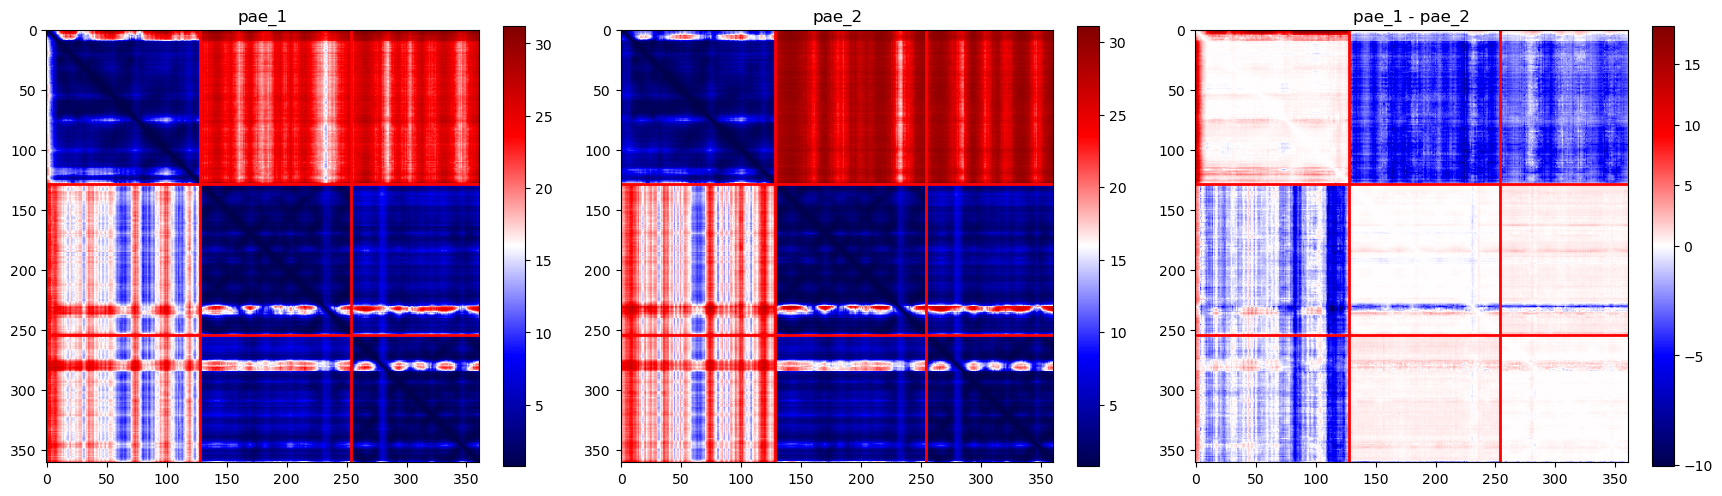

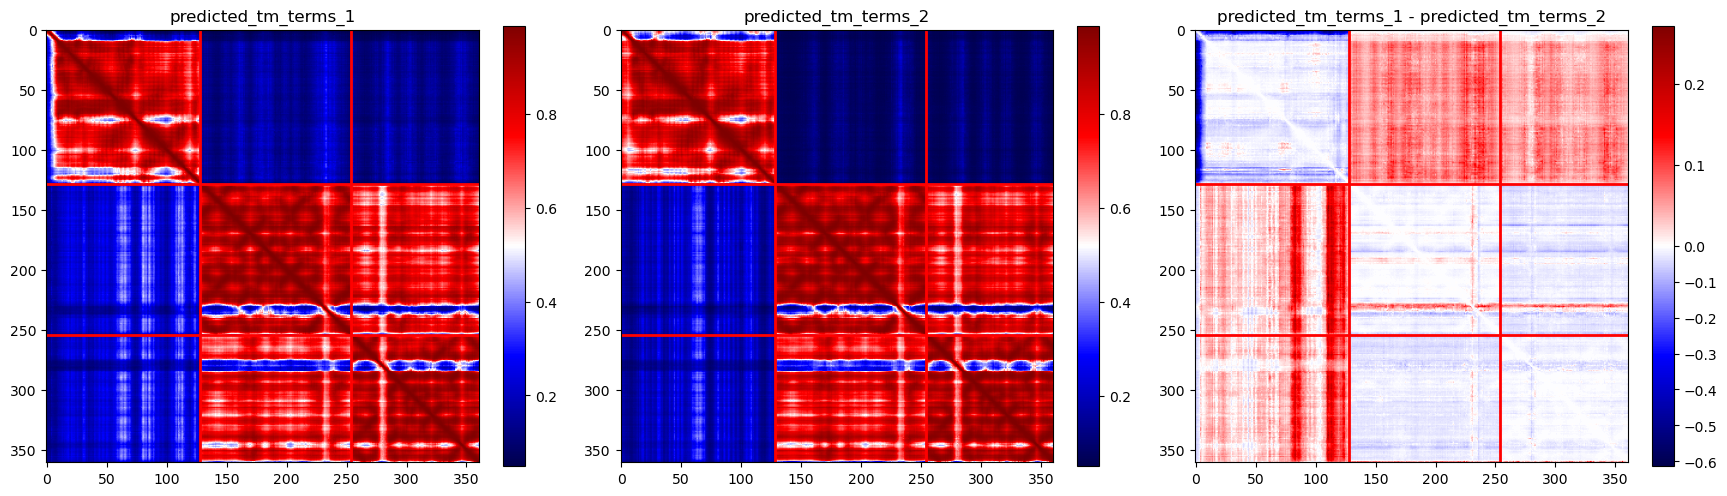

In [17]:

plot_matrix(
    mat1=pae1,
    mat2=pae2,
    name1='pae_1',
    name2='pae_2',
    limits1=get_chain_limits(asym_id_1),
    limits2=get_chain_limits(asym_id_2),
    #title="Predicted Aligned Error"
)

plot_matrix(
    mat1=predicted_tm_terms_1,
    mat2=predicted_tm_terms_2,
    name1='predicted_tm_terms_1',
    name2='predicted_tm_terms_2',
    limits1=get_chain_limits(asym_id_1),
    limits2=get_chain_limits(asym_id_2),
    #title="Predicted TM Terms"
)